# EOF analysis 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from xeofs.models import EOF

Without worrying about the nuts and bolts of an EOF analysis, we can try the `xeofs` Python package which allows us to derive EOF patterns with xarray datasets.

In [2]:
import xeofs
print(xeofs.__version__)

2.3.2


In [3]:
model = EOF(n_modes=5)

In [4]:
data_dir = '/work/jet/sea_level_covariability/data/zarr/'
fname = 'AVISO_global_1994to2020_zos_monthly'
ds = xr.open_zarr(f'{data_dir+fname}',use_cftime=True)

In [5]:
model.fit(ds.zos, dim=("yh", "xh"))
expvar = model.explained_variance_ratio()
components = model.components()
scores = model.scores()

In [6]:
from cartopy.crs import EqualEarth, PlateCarree

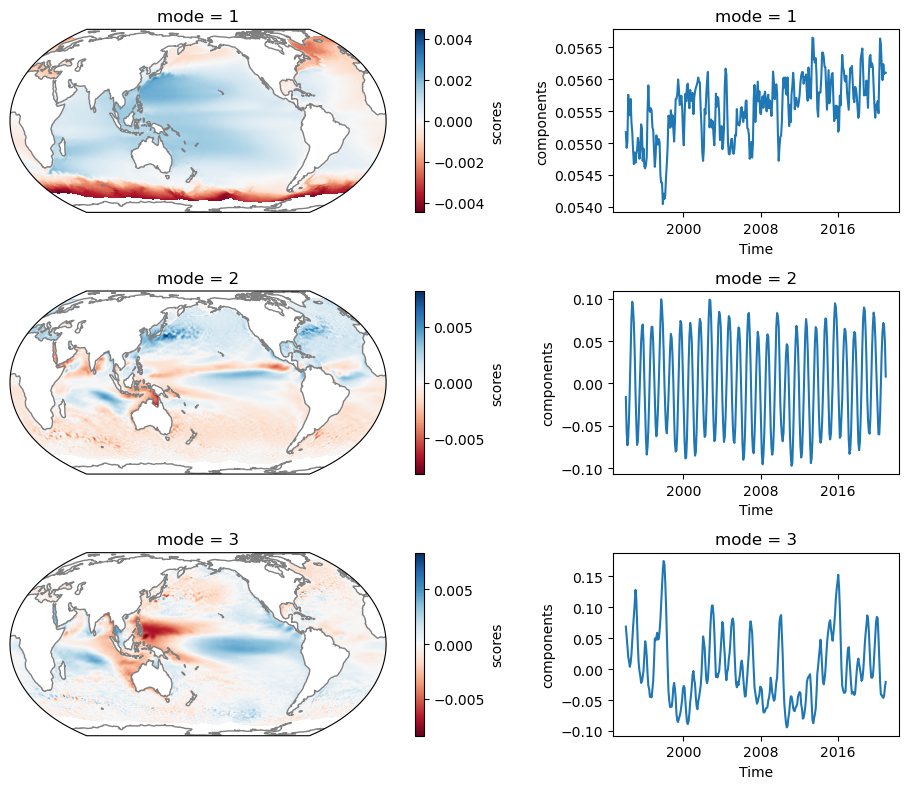

In [7]:
proj = EqualEarth(central_longitude=180)
kwargs = {"cmap": "RdBu", "transform": PlateCarree()}

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 2, width_ratios=[2, 1])
ax0 = [fig.add_subplot(gs[i, 0], projection=proj) for i in range(3)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(3)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    scores.sel(mode=i + 1).plot(ax=a0, **kwargs)
    a0.coastlines(color=".5")
    components.sel(mode=i + 1).plot(ax=a1)
    a0.set_xlabel("")

plt.tight_layout()
plt.show()

When using the raw data, the two leading modes primarily represent a global trend and the seasonal cycle. Let's remove the trend and seasonality before performing the EOF analysis.

In [8]:
import momlevel

In [9]:
da = ds.zos-ds.zos.mean('time')
da_anm = da.groupby('time.month') - da.groupby('time.month').mean('time')
da_dtr = momlevel.trend.linear_detrend(da_anm)

/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 27 times more chunks
  return self.array[key]


In [10]:
#model = EOF(n_modes=5)
model = EOF(n_modes=3,standardize=True,verbose=True)
model.fit(da_dtr, dim=("yh", "xh"))
expvar = model.explained_variance_ratio()
components = model.components()
scores = model.scores()

[########################################] | 100% Completed | 65.69 s


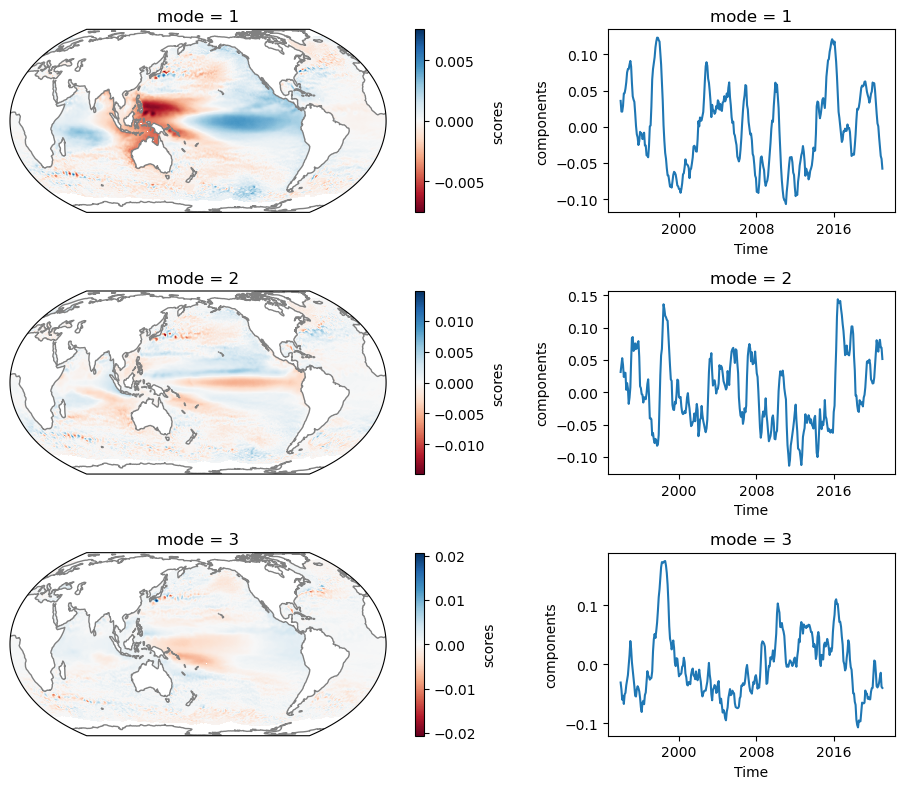

In [11]:
proj = EqualEarth(central_longitude=180)
kwargs = {"cmap": "RdBu", "transform": PlateCarree()}

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 2, width_ratios=[2, 1])
ax0 = [fig.add_subplot(gs[i, 0], projection=proj) for i in range(3)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(3)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    scores.sel(mode=i + 1).plot(ax=a0, **kwargs)
    a0.coastlines(color=".5")
    components.sel(mode=i + 1).plot(ax=a1)

    a0.set_xlabel("")

plt.tight_layout()
plt.show()

After removing the trend and seasonal cycle, the leading EOF modes reflect intrinsic variability that is heavily influeced by ENSO variability in the Pacific.

- Compare these patterns with what you see in the skewness and kurtosis plots in `DSL_statisitics.ipynb`.

## A more detailed walkthrough of an EOF analysis using `numpy` and `scipy.linalg.svd`

In [12]:
import numpy as np

### Define good locations
Find pixel locations where all the data is present for each time point. If even one time point at a given location is missing, that location will be excluded from the eof analysis

In [13]:
# Ensure the data is loaded as a Dask array
da_dtr = da_dtr.chunk({'time': 1})

In [14]:
# Sum of finite values along the 'time' dimension
flattened_array = xr.apply_ufunc(np.isfinite, da_dtr, dask='parallelized', output_dtypes=[bool]).sum(dim='time')

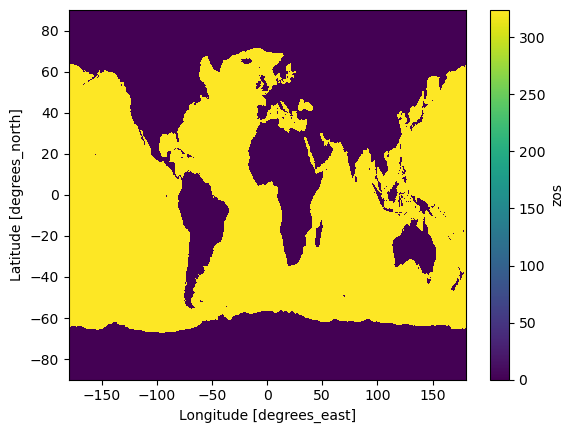

In [15]:
flattened_array.plot()

The map shows the number of time points with valid data.

In [16]:
# Locations in the 2D array that have all good data for all time points
good_locations = flattened_array == len(da_dtr.time)

In [17]:
# Get indices of good locations
good_indices = np.where(good_locations.values)

### Create EOF matrix

In [18]:
# Create an empty array for the EOF matrix
n = len(da_dtr.time)
eof_matrix = np.zeros((n, len(good_indices[0])), dtype=float)

In [19]:
# Load interim data file and convert to numpy array
eof_matrix = xr.open_dataset('eof_matrix_da.nc').eof_matrix_da.values

### Normalize each time series
Normalize the time series at each location by dividing by the standard deviation of the data at the respective location.

In [20]:
stdv_geophys = np.asarray(list(map(np.sqrt, np.sum(eof_matrix**2.0, axis=0)))) / (n - 1)

for i in range(n):
    eof_matrix[i, :] = eof_matrix[i, :] / stdv_geophys

### Singular Value Decomposition
Note: Transpose is taken becaue svd function expects a matrix that has vectors that are trasnposed relative to how the data were orginally read into the `eof_matrix`.

In [21]:
from scipy.linalg import svd

In [22]:
eof_matrix = np.transpose(eof_matrix)

U, S, V = svd(eof_matrix,full_matrices=False)

### Calculate variances

In [23]:
variances = 100.0*S**2/np.sum(S**2)

### Singular values

In [24]:
s_matrix= np.zeros((n, n))

for i in range(n):
    s_matrix[i,i]=S[i]

### PC timeseries

In [25]:
svdc_time_series = np.dot(s_matrix,V)

### Sort index
Sort eof/svd index order so that each eof mode variance explained goes from mode with the highest amount of orginal variance explained to mode with least amount of variance explained. This gives output with mode 1 having the highest explained variance.

In [26]:
sorted_var_index = np.argsort(-variances)

In [27]:
print('%s-%s:'%(str(int(da_dtr.time[0].dt.year.values)),str(int(da_dtr.time[-1].dt.year.values))))
print('1:', variances[sorted_var_index[0]])
print('2:', variances[sorted_var_index[1]])
print('3:', variances[sorted_var_index[2]])

1994-2020:
1: 10.06662589805442
2: 3.372590262407724
3: 3.139456726538471


In [33]:
# Compare to xeofs (explained_variance_ratio)
expvar.to_dataframe(name='explained_variance')*100

,explained_variance
mode,
1,7.263911
2,2.449253
3,2.142651


### Set dimensions

In [34]:
xdim = np.shape(da_dtr)[2]
ydim = np.shape(da_dtr)[1]

### Spatial Eigenfunction

In [35]:
arr_img = np.zeros((ydim,xdim)) + np.nan

### Map 1st mode

In [36]:
arr_img[good_indices[0],good_indices[1]] = U[:,sorted_var_index[0]]

In [37]:
# Use +/- (1.0) to change the color coding of weights
pc_normalize_factor = np.nanmax(abs(arr_img))*(-1.0)
eof01 = arr_img/pc_normalize_factor

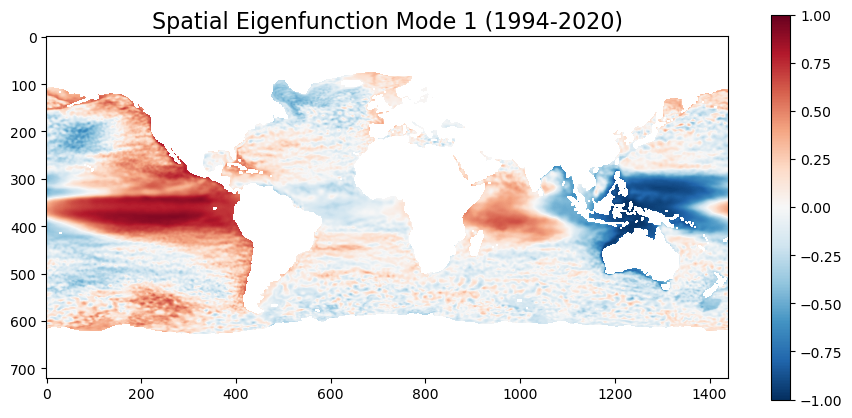

In [40]:
plt.figure(figsize=(11,5))
plt.title('Spatial Eigenfunction Mode 1 (%s-%s)'%(str(int(da_dtr.time[0].dt.year.values)),
                                                  str(int(da_dtr.time[-1].dt.year.values))),fontsize=16)
plt.imshow(np.flipud(eof01), cmap='RdBu_r', vmin=-1.0, vmax=1.0)
plt.colorbar(orientation='vertical')
plt.show()

This corrsponds pretty closely to the first EOF pattern we obtained with `xeofs`. Let's compare the principle component time series of the first mode.

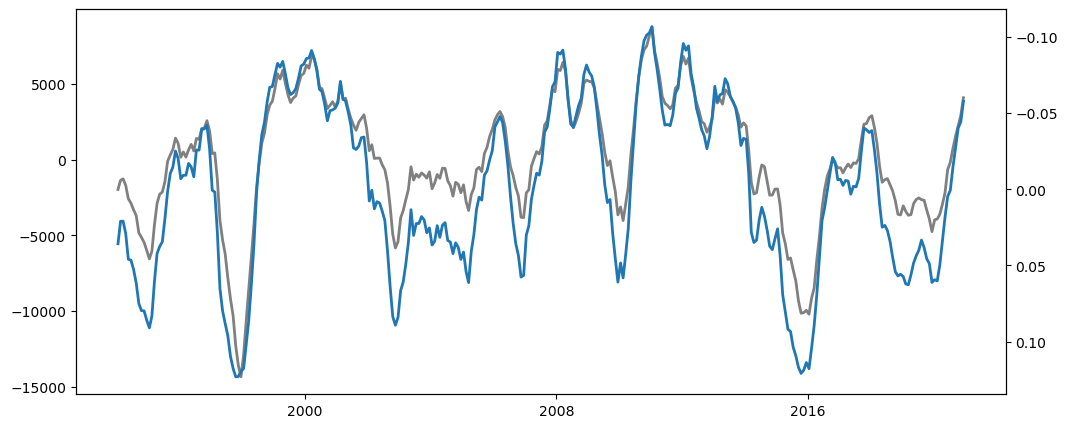

In [53]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(da_dtr.time,svdc_time_series[sorted_var_index[0],:], lw=2, color='grey')
ax_ = ax.twinx()
components.sel(mode=1).plot(ax=ax_,ls='-', lw=2,yincrease=False,_labels=False)
plt.show()

Taking into account the difference in normalization and sign convention, we can see that the results are fairly robust between the two methods.